<h1 style="color:Orange;font-size:170%;">New York City Taxi Fare Prediction</h>



![](Taxi.jpg)

Dataset Link: [https://www.kaggle.com/c/new-york-city-taxi-fare-prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

We'll train a machine learning model to predict the fare for a taxi ride in New York city given information like pickup date & time, pickup location, drop location and no. of passengers. 

This dataset is taken from a [Kaggle competition](ttps://www.kaggle.com/c/new-york-city-taxi-fare-prediction) organized by Google Cloud.
It contains over 55 millions rows of training data. We'll attempt to achieve a respectable score in the competition using just a fraction of the data.
Along the way, we'll also look at some practical tips for machine learning. PMost of the ideas & techniques covered in this notebook are derived from
other public notebooks & blog posts.




> _**TIP #1**: Create an outline for your notebook & for each section before you start coding_



Here's an outline of the project:

1. Download the dataset
2. Explore & analyze the dataset
3. Prepare the dataset for ML training
4. Train hardcoded & baseline models
5. Make predictions & submit to Kaggle
6. Perform feature engineering
7. Train & evaluate different models
8. Tune hyper-parameters for the best models
9. Train on a GPU with the entire dataset
10. Document & publish the project online


## 1. Download the Dataset

Steps:

- Install required libraries
- Download data from Kaggle
- View dataset files
- Load training set with Pandas
- Load test set with Pandas

### Install Required Libraries

In [6]:
!pip install opendatasets --upgrade
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
!pip install xgboost

In [321]:
import opendatasets as od
import pandas as pd
import random
import time
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


%autosave 60

Autosaving every 60 seconds


### Download Data from Kaggle

We'll use the [opendatasets](https://github.com/JovianML/opendatasets) library to download the dataset. You'll need to download your Kaggle API key that is a file called `kaggle.json` from Kaggle. Log-in to Kaggle and go to *Profile picture -> Account -> API -> Create New API* and download it on the same folder as the project.

In [8]:
dataset_url = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'
od.download(dataset_url)

  0%|          | 0.00/1.56G [00:00<?, ?B/s]

100%|██████████| 1.56G/1.56G [08:15<00:00, 3.38MB/s]



Extracting archive .\new-york-city-taxi-fare-prediction/new-york-city-taxi-fare-prediction.zip to .\new-york-city-taxi-fare-prediction


In [3]:
# The dataset will be save in a folder called 'new-york-city-taxi-fare-prediction'. We save that folder as data_dir so it will be more handy in case we need to access the data.
data_dir = 'new-york-city-taxi-fare-prediction'

### View Dataset Files

Let's look at the size, no. of lines and first few lines of each file.

In [4]:
# We can check the content of the folder as follow:
!dir -l {data_dir}

 Volume in drive D is DATA

File Not Found



 Volume Serial Number is 284D-6F1A

 Directory of D:\Data Projects\Data_Science_Analysis_Projects\Machine Learning\New York Taxi Fare Prediction


 Directory of D:\Data Projects\Data_Science_Analysis_Projects\Machine Learning\New York Taxi Fare Prediction\new-york-city-taxi-fare-prediction

14/11/2021  13:03    <DIR>          .
14/11/2021  13:03    <DIR>          ..
14/11/2021  13:03               486 GCP-Coupons-Instructions.rtf
14/11/2021  13:03           343'271 sample_submission.csv
14/11/2021  13:03           983'020 test.csv
14/11/2021  13:03     5'697'178'298 train.csv
               4 File(s)  5'698'505'075 bytes
               2 Dir(s)  132'261'031'936 bytes free


Using a whole dataset will make iteration slower. A good practice is that to use a small sample to experiment and iterate faster. Upload the entire dataset in pandas will be slow and also all the afterwards operations will be affected.
We will work with a 1% sample of the data (~500k rows ~ hals of the test set size) and at the END come back and work with the entire dataset.

In [215]:
df_train_val = pd.read_csv(data_dir + "/train.csv")
df_train_val.shape

(55423856, 8)

In [15]:
df_train_val.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [172]:
df_test = pd.read_csv(data_dir + "/test.csv")
df_test.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

The test data look similar to train data except for the **fair amount** that is the **target column** since we must to predict it. For submitting the preditcion to Kaggle we need a submission file which looks like this:

In [18]:
df_sample_sub = pd.read_csv(data_dir + "/sample_submission.csv")
df_sample_sub.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


You notice that the key values correspond exactly to the test set. The fare_amont corresponds to the predicted value of out model. In this case the values are 11.35 only because is a sample file. Once you test the model and filled this the submission file you can submit the file to the kaggle competition on the late section [here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/submit) for check you model score. Feel free to compare your score with the leader board to sse how much your model can be optimized.

Observations:

- This is a supervised learning regression problem
- Training data is 5.5 GB in size
- Training data has 5.5 million rows
- Test set is much smaller (< 10,000 rows)
- The training set has 8 columns:
    - `key` (a unique identifier)
    - `fare_amount` (target column)
    - `pickup_datetime`
    - `pickup_longitude`
    - `pickup_latitude`
    - `dropoff_longitude`
    - `dropoff_latitude`
    - `passenger_count`
- The test set has all columns except the target column `fare_amount`.
- The submission file should contain the `key` and `fare_amount` for each test sample.



### Loading Training Set

> _**TIP #2**: When working with large datasets, always start with a sample to experiment & iterate faster._

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the `key` column
- Parse pickup datetime while loading data 
- Specify data types for other columns
   - `float32` for geo coordinates
   - `float32` for fare amount
   - `uint8` for passenger count
- Work with a 1% sample of the data (~500k rows)

We can apply these optimizations while using [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [28]:
sel_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
sel_cols

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [35]:
dtypes = {
    'fare_amount' : 'float32',
    'pickup_longitude' : 'float32',
    'pickup_latitude' : 'float32',
    'dropoff_longitude' : 'float32',
    'dropoff_latitude' : 'float32',
    'passenger_count' : 'uint8'
}

In [36]:
def skiprow(row_idx):
    """
    This function return a True value with a probability defined by the sample_fraction.
    The first row will always took.
    Input arg: row_idx
    Output arg: Boolean

    """

    if row_idx == 0: # Keep the first row
        return False
    return random.random() > sample_fraction # If random is greater than samplefration (which is 99% of probability it will skip the row

In [38]:
elapsed = {
    "1%" : 0,
    "3%" : 0,
    "10%": 0,
    "30%": 0,
    "100%": 0
}

In [216]:
random.seed(42)

# 1% of the data
t = time.time()
sample_fraction = 0.01

# df_train_val = pd.read_csv(data_dir + "/train.csv",usecols = sel_cols, dtype = dtypes, nrows = 500)
df_train_val = pd.read_csv(data_dir + "/train.csv",
                       usecols = sel_cols,
                       parse_dates = ['pickup_datetime'], # the types datetime need to pass separately
                       dtype = dtypes,
                       skiprows = skiprow)
elapsed["1%"] = round((time.time() - t)/60,2)

> _**TIP #3**: Fix the seeds for random number generators so that you get the same results every time you run your notebook._

**Exercise**: Try loading 3%, 10%, 30% and 100% of the data.

In [50]:
# 3% of the data
t = time.time()
sample_fraction = 0.03

# df_train_val = pd.read_csv(data_dir + "/train.csv",usecols = sel_cols, dtype = dtypes, nrows = 500)
df_train_val_time = pd.read_csv(data_dir + "/train.csv",
                            usecols = sel_cols,
                            parse_dates = ['pickup_datetime'],
                            dtype = dtypes,
                            skiprows = skiprow)
elapsed["3%"] = round((time.time() - t)/60,2)


In [51]:
# 10% of the data
t = time.time()

sample_fraction = 0.1

# df_train_val = pd.read_csv(data_dir + "/train.csv",usecols = sel_cols, dtype = dtypes, nrows = 500)
df_train_val_time = pd.read_csv(data_dir + "/train.csv",
                            usecols = sel_cols,
                            parse_dates = ['pickup_datetime'],
                            dtype = dtypes,
                            skiprows = skiprow)

elapsed["10%"] = round((time.time() - t)/60,2)
elapsed

{'1%': 2.39, '3%': 4.99, '10%': 13.83, '30%': 0, '100%': 0}

In [52]:
# 30% of the data
t = time.time()

sample_fraction = 0.3

# df_train_val = pd.read_csv(data_dir + "/train.csv",usecols = sel_cols, dtype = dtypes, nrows = 500)
df_train_val_time = pd.read_csv(data_dir + "/train.csv",
                            usecols = sel_cols,
                            parse_dates = ['pickup_datetime'],
                            dtype = dtypes,
                            skiprows = skiprow)

elapsed["30%"] = round((time.time() - t)/60,2)
elapsed

{'1%': 2.39, '3%': 4.99, '10%': 13.83, '30%': 38.3, '100%': 0}

In [53]:
# 100% of the data
t = time.time()

sample_fraction = 1

# df_train_val = pd.read_csv(data_dir + "/train.csv",usecols = sel_cols, dtype = dtypes, nrows = 500)
df_train_val_time = pd.read_csv(data_dir + "/train.csv",
                            usecols = sel_cols,
                            parse_dates = ['pickup_datetime'],
                            dtype = dtypes,
                            skiprows = skiprow)

elapsed["100%"] = round((time.time() - t)/60,2)

In [57]:
del df_train_val_time

In [54]:
elapsed # In minutes

{'1%': 2.39, '3%': 4.99, '10%': 13.83, '30%': 38.3, '100%': 124.74}

### Load Test Set

For the test set, we'll simply provide the data types.

In [203]:
df_test = pd.read_csv(data_dir + "/test.csv",dtype=dtypes, parse_dates=['pickup_datetime'])

In [56]:
df_test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6


In [58]:
df_train_val

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755482,1
1,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2
2,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766964,3
3,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1
4,7.0,2013-11-06 11:26:54+00:00,-73.959061,40.781059,-73.962059,40.768604,1
...,...,...,...,...,...,...,...
552445,45.0,2014-02-06 23:59:45+00:00,-73.973587,40.747669,-73.999916,40.602894,1
552446,22.5,2015-01-05 15:29:08+00:00,-73.935928,40.799656,-73.985710,40.726952,2
552447,4.5,2013-02-17 22:27:00+00:00,-73.992531,40.748619,-73.998436,40.740143,1
552448,14.5,2013-01-27 12:41:00+00:00,-74.012115,40.706635,-73.988724,40.756218,1


## 2. Explore the Dataset

- Basic info about training set
- Basic info about test set
- Exploratory data analysis & visualization
- Ask & answer questions

### Training Set

In [61]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 15.3 MB


In [82]:
df_train_val.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354463,-72.288383,39.830513,-72.295395,39.854305,1.684983
std,9.810809,11.622035,8.041162,12.065184,9.226158,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


As we can see that half of the fre is costing less than 8 dollar. That's give us an idea how good our model need to be. An ideal variance of the prediction can be 3 dollars, more than this will be too much. There are some value dirty as negative fare, pickup longitude as -1183 which is not valid (a lot out of the area), and a max passenger of 208.

In [83]:
df_train_val["pickup_datetime"].min(),df_train_val["pickup_datetime"].max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

Observations about training data:

- 550k+ rows, as expected
- No missing data (in the sample)
- `fare_amount` ranges from \$-52.0 to \$499.0 
- `passenger_count` ranges from 0 to 208 
- There seem to be some errors in the latitude & longitude values
- Dates range from 1st Jan 2009 to 30th June 2015
- The dataset takes up ~19 MB of space in the RAM

We may need to deal with outliers and data entry errors before we train our model.


### Test Set

In [84]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                9914 non-null   object 
 1   pickup_datetime    9914 non-null   object 
 2   pickup_longitude   9914 non-null   float32
 3   pickup_latitude    9914 non-null   float32
 4   dropoff_longitude  9914 non-null   float32
 5   dropoff_latitude   9914 non-null   float32
 6   passenger_count    9914 non-null   uint8  
dtypes: float32(4), object(2), uint8(1)
memory usage: 319.6+ KB


In [85]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.976181,40.750954,-73.974945,40.751553,1.671273
std,0.042799,0.033542,0.039093,0.035436,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


Since we have a huge amount of data we can drop the data from the training set which fall out the test set data.

In [68]:
df_test["pickup_datetime"].min(),df_test["pickup_datetime"].max()

('2009-01-01 11:04:24 UTC', '2015-06-30 20:03:50 UTC')

Some observations about the test set:

- 9914 rows of data
- No missing values
- No obvious data entry errors
- 1 to 6 passengers (we can limit training data to this range)
- Latitudes lie between 40 and 42
- Longitudes lie between -75 and -72
- Pickup dates range from Jan 1st 2009 to Jun  30th 2015 (same as training set)

We can use the ranges of the test set to drop outliers/invalid data from the training set.

### Exploratory Data Analysis and Visualization

Create graphs (histograms, line charts, bar charts, scatter plots, box plots, geo maps etc.) to study the distrubtion of values in each column, and the relationship of each input column to the target.



### Ask & Answer Questions

**Exercise**: Ask & answer questions about the dataset: 

1. What is the busiest day of the week?
2. What is the busiest time of the day?
3. In which month are fares the highest?
4. Which pickup locations have the highest fares?
5. Which drop locations have the highest fares?
6. What is the average ride distance?
7. ???

Performing EDA on your dataset and asking questions will help you develop a deeper understand of the data and give you ideas for feature engineering.



Resources for exploratory analysis & visualization:

- EDA project from scratch: [https://www.youtube.com/watch?v=kLDTbavcmd0](https://www.youtube.com/watch?v=kLDTbavcmd0)
- Data Analysis with Python: [https://zerotopandas.com](https://zerotopandas.com)

> _**TIP #4**: Take an iterative approach to building ML models: do some EDA, do some feature engineering, train a model, then repeat to improve your model._

## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

### Split Training & Validation Set

We'll set aside 20% of the training data as the validation set, to evaluate the models we train on previously unseen data. 

Since the test set and training set have the same date ranges, we can pick a random 20% fraction.

> _**TIP #5**: Your validation set should be as similar to the test set or real-world data as possible i.e. the evaluation metric score of a model on validation & test sets should be very close, otherwise you're shooting in the dark._


Try also with StratifiedShuffleSplit method

In [95]:
train_df, val_df = train_test_split(df_train_val, test_size=0.2, random_state=42) # We set random_state=42 so we always have the same test and val data

In [96]:
len(train_df), len(val_df)

(441960, 110490)

In [ ]:
# StShSp = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#
# for train_idx, valid_idx in StShSp.split(df_train_val, df_train_val["fare_amount"]):
#     train_data = train_df.loc[train_idx]
#     valid_data = train_df.loc[valid_ids]
# train_data['price_category'].value_counts() / len(train_data), test_data['price_category'].value_counts()/len(test_data)

### Fill/Remove Missing Values

There are no missing values in our sample, but if there were, we could simply drop the rows with missing values instead of trying to fill them (since we have a lot of training data)> Since the missinga value is estimated around 1% or 2% and we have many data we can drop this values.

In [101]:
train_df = train_df.dropna()
val_df = val_df.dropna()

### Extract Inputs and Outputs
Before create a model we need to separate the input and the outputs columns.

In [114]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

We can't pass a datetime colum into a ML model by himself because it's a timestamp not a number. We need to convert that column into sum or split it into multiple columns

In [115]:
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [116]:
target_cols = 'fare_amount'

#### Training

In [117]:
train_inputs = train_df[input_cols]
train_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
353352,-73.993652,40.741543,-73.977974,40.742352,4
360070,-73.993805,40.724579,-73.993805,40.724579,1
372609,-73.959160,40.780750,-73.969116,40.761230,1
550895,-73.952187,40.783951,-73.978645,40.772602,1
444151,-73.977112,40.746834,-73.991104,40.750404,2
...,...,...,...,...,...
110268,-73.987152,40.750633,-73.979073,40.763168,1
259178,-73.972656,40.764042,-74.013176,40.707840,2
365838,-73.991982,40.749767,-73.989845,40.720551,3
131932,-73.969055,40.761398,-73.990814,40.751328,1


In [126]:
train_targets = train_df[target_cols]
train_targets

353352     6.0
360070     3.7
372609    10.0
550895     8.9
444151     7.3
          ... 
110268     9.3
259178    18.5
365838    10.1
131932    10.9
121958     9.5
Name: fare_amount, Length: 441960, dtype: float32

#### Validation

In [127]:
val_inputs = val_df[input_cols]
val_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
15971,-73.995834,40.759190,-73.973679,40.739086,1
149839,-73.977386,40.738335,-73.976143,40.751205,1
515867,-73.983910,40.749470,-73.787170,40.646645,1
90307,-73.790794,40.643463,-73.972252,40.690182,1
287032,-73.976593,40.761944,-73.991463,40.750309,2
...,...,...,...,...,...
467556,-73.968567,40.761238,-73.983406,40.750019,3
19482,-73.986725,40.755920,-73.985855,40.731171,1
186063,0.000000,0.000000,0.000000,0.000000,1
382260,-73.980057,40.760334,-73.872589,40.774300,1


In [128]:
val_targets = val_df[target_cols]
val_targets

15971     14.000000
149839     6.500000
515867    49.570000
90307     49.700001
287032     8.500000
            ...    
467556     6.100000
19482      7.300000
186063     4.500000
382260    32.900002
18838     11.500000
Name: fare_amount, Length: 110490, dtype: float32

#### Test

In [129]:
test_inputs = df_test[input_cols]
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


## 4. Train Hardcoded & Baseline Models

> _**TIP #6**: Always create a simple hardcoded or baseline model to establish the minimum score any proper ML model should beat._

- Hardcoded model: always predict average fare
- Baseline model: Linear regression 

For evaluation the dataset uses RMSE error: 
[https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation)

### Train & Evaluate Hardcoded Model

Let's create a simple model that always predicts the average. It can be trained very quickly and can establish the minimum score that any proper ML should beat. It serve to test if what we are doing is correct and give a base line to beat.

In [173]:
class MeanRegressor:
    def __init__(self):
        self.mean = None
    
    def fit(self, inputs, targets):
        self.mean = targets.mean()

    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean) # np.full(# of rows, mean)

In [176]:
mean_model = MeanRegressor()
mean_model.fit(train_inputs, train_targets)

mean_model.mean

11.354591369628906

This model ignores the inputs and calculate the average of the targets and stor it on the variable mean. This is the average spread of the fairs. When we want have some prediction

In [146]:
train_predicts = mean_model.predict(train_inputs)
train_predicts

array([11.35459137, 11.35459137, 11.35459137, ..., 11.35459137,
       11.35459137, 11.35459137])

In [149]:
# We want to compare with the targets
train_targets

353352     6.0
360070     3.7
372609    10.0
550895     8.9
444151     7.3
          ... 
110268     9.3
259178    18.5
365838    10.1
131932    10.9
121958     9.5
Name: fare_amount, Length: 441960, dtype: float32

As we can see some value are far but we will setup a metric to determine how well we pwrformed.

In [148]:
val_predicts = mean_model.predict(val_inputs)
val_predicts

array([11.35459137, 11.35459137, 11.35459137, ..., 11.35459137,
       11.35459137, 11.35459137])

In [150]:
val_targets

15971     14.000000
149839     6.500000
515867    49.570000
90307     49.700001
287032     8.500000
            ...    
467556     6.100000
19482      7.300000
186063     4.500000
382260    32.900002
18838     11.500000
Name: fare_amount, Length: 110490, dtype: float32

Let's compute an RMSE to have a value of our performance

In [153]:
def rmse(targets, preds):
    return mean_squared_error(targets, preds, squared = False)

In [154]:
train_rmse = rmse(train_targets, train_predicts)
train_rmse

9.78978199423857

This prediction is quite bad since is the mean variance of the actual price. This actually is expected because is a dumb model, but the point is to have a baseline for improvement.

In [156]:
val_rmse = rmse(val_targets, val_predicts)
val_rmse

9.899954151552434

Our dumb hard-coded model is off by  9.899 on average, which is pretty bad considering the average fare is 11.35.

### Train & Evaluate Baseline Model

We'll train a linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [158]:
linear_model = LinearRegression()

In [159]:
linear_model.fit(train_inputs, train_targets)

LinearRegression()

In [161]:
train_preds = linear_model.predict(train_inputs)

In [162]:
train_preds

array([11.546229 , 11.284613 , 11.2841425, ..., 11.458913 , 11.284283 ,
       11.284451 ], dtype=float32)

In [163]:
train_targets

353352     6.0
360070     3.7
372609    10.0
550895     8.9
444151     7.3
          ... 
110268     9.3
259178    18.5
365838    10.1
131932    10.9
121958     9.5
Name: fare_amount, Length: 441960, dtype: float32

The prediction still close to 11 but they are not the same value like before

In [164]:
rmse( train_targets, train_preds )

9.788632

In [168]:
val_preds = linear_model.predict(val_inputs)
val_preds

array([11.28433  , 11.284498 , 11.284783 , ..., 11.8045025, 11.284436 ,
       11.284135 ], dtype=float32)

In [171]:
rmse(val_targets, val_preds ) # 0.1 better than average model

9.898088

The linear regression model is off by $9.898, which isn't much better than simply predicting the average. 

This is mainly because the training data (geocoordinates) is not in a format that's useful for the model, and we're not using one of the most important columns: pickup date & time.

However, now we have a baseline that our other models should ideally beat.

## 5. Make Predictions and Submit to Kaggle

> _**TIP #7**: When working on a Kaggle competition, submit early and submit often (ideally daily). The best way to improve your models is to try & beat your previous score._

- Make predictions for test set
- Generate submissions CSV
- Submit to Kaggle
- Record in experiment tracking sheet

In [177]:
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


In [189]:
test_preds = linear_model.predict(test_inputs)

In [182]:
sub_df = pd.read_csv(data_dir + '/sample_submission.csv')
sub_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [184]:
sub_df['fare_amount'] = test_preds
sub_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.284283
1,2015-01-27 13:08:24.0000003,11.284636
2,2011-10-08 11:53:44.0000002,11.284387
3,2012-12-01 21:12:12.0000002,11.284225
4,2012-12-01 21:12:12.0000003,11.284052
...,...,...
9909,2015-05-10 12:37:51.0000002,11.720262
9910,2015-01-12 17:05:51.0000001,11.720210
9911,2015-04-19 20:44:15.0000001,11.721233
9912,2015-01-31 01:05:19.0000005,11.720783


In [186]:
# For upload to kaggle we need index= None or pandas will ad also the index column and we will have 2 index column
sub_df.to_csv(data_dir + 'linear_model_submission.csv', index=None)

The submission was evaluate 9.4 which is close to our rmse 9.78 considering that we only use 10% of the dataset.

> _**TIP #8**: Create reusable functions for common tasks. They'll help you iterate faster and free up your mind to think about new ideas._

In [196]:
def predict_and_submit(model, test_inputs, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(data_dir +'/'+ fname, index=None)
    return sub_df

In [195]:
predict_and_submit(linear_model, test_inputs, 'linear_submission2.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.284283
1,2015-01-27 13:08:24.0000003,11.284636
2,2011-10-08 11:53:44.0000002,11.284387
3,2012-12-01 21:12:12.0000002,11.284225
4,2012-12-01 21:12:12.0000003,11.284052
...,...,...
9909,2015-05-10 12:37:51.0000002,11.720262
9910,2015-01-12 17:05:51.0000001,11.720210
9911,2015-04-19 20:44:15.0000001,11.721233
9912,2015-01-31 01:05:19.0000005,11.720783


Now instead of doing manually the process to generate the submission we can just call a function.

> _**TIP #9**: Track your ideas & experiments systematically to avoid become overwhelmed with dozens of models. Use this template: https://bit.ly/mltrackingsheet_

## 6. Feature Engineering

> _**TIP #10**: Take an iterative approach to feature engineering. Add some features, train a model, evaluate it, keep the features if they help, otherwise drop them, then repeat._

- Extract parts of date
- Remove outliers & invalid data
- Add distance between pickup & drop
- Add distance from landmarks

Exercise: We're going to apply all of the above together, but you should observer the effect of adding each feature individually.

### Extract Parts of Date

- Year
- Month
- Day
- Weekday
- Hour



In [199]:
def add_dateparts(df, col):
    """
    This function splits the datetime column into separate column such year, month, day, weekday, and hour
    :param df: dataframe where to add the columns
    :param col: the column with datetime values
    :return: None
    """
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [205]:
add_dateparts(train_df, 'pickup_datetime')

In [206]:
add_dateparts(val_df, 'pickup_datetime')

In [207]:
add_dateparts(df_test, 'pickup_datetime')

In [209]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15
...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1,2009,9,6,6,16
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2,2009,4,12,6,9
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3,2012,7,12,3,19
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1,2011,2,17,3,18


In [210]:
val_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
15971,14.000000,2015-05-19 09:27:24+00:00,-73.995834,40.759190,-73.973679,40.739086,1,2015,5,19,1,9
149839,6.500000,2010-04-10 15:07:51+00:00,-73.977386,40.738335,-73.976143,40.751205,1,2010,4,10,5,15
515867,49.570000,2009-07-25 14:11:00+00:00,-73.983910,40.749470,-73.787170,40.646645,1,2009,7,25,5,14
90307,49.700001,2011-11-11 19:09:21+00:00,-73.790794,40.643463,-73.972252,40.690182,1,2011,11,11,4,19
287032,8.500000,2015-03-09 18:06:44+00:00,-73.976593,40.761944,-73.991463,40.750309,2,2015,3,9,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...
467556,6.100000,2010-04-03 20:16:00+00:00,-73.968567,40.761238,-73.983406,40.750019,3,2010,4,3,5,20
19482,7.300000,2010-04-26 00:32:00+00:00,-73.986725,40.755920,-73.985855,40.731171,1,2010,4,26,0,0
186063,4.500000,2009-05-21 08:13:16+00:00,0.000000,0.000000,0.000000,0.000000,1,2009,5,21,3,8
382260,32.900002,2011-07-07 16:10:59+00:00,-73.980057,40.760334,-73.872589,40.774300,1,2011,7,7,3,16


In [211]:
df_test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21
...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,6,12
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,0,17
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,6,20
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,5,1


As we can see the pickup_datetime has split in separate columns.

### Add Distance Between Pickup and Drop

We can use the haversine distance: 
- https://en.wikipedia.org/wiki/Haversine_formula
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

In [217]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [218]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'],
                                       df['pickup_latitude'],
                                       df['dropoff_longitude'],
                                       df['dropoff_latitude'])

In [232]:
add_trip_distance(train_df)
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3,1.323411,20.241218,9.556491,17.564265,4.300619,4.261556
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19,0.000000,20.397342,11.641279,15.712975,6.614260,1.900087
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10,2.325504,20.894635,8.192380,19.044720,2.079640,6.402743
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13,2.558912,22.322590,8.819258,18.901976,1.503380,7.168226
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15,1.243267,21.657923,10.286740,16.863731,3.987247,4.489272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1,2009,9,6,6,16,1.549976,21.680532,8.973312,18.381542,2.244531,6.189856
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2,2009,4,12,6,9,7.116529,21.146751,14.007071,13.743641,8.996681,0.596623
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3,2012,7,12,3,19,3.251601,19.899211,11.590020,15.933433,6.913821,1.906013
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1,2011,2,17,3,18,2.146101,21.694902,10.234066,16.927621,3.890083,4.593892


In [233]:
add_trip_distance(val_df)
val_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
15971,14.000000,2015-05-19 09:27:24+00:00,-73.995834,40.759190,-73.973679,40.739086,1,2015,5,19,1,9,2.909793,19.739844,9.383944,17.789850,4.565850,4.238753
149839,6.500000,2010-04-10 15:07:51+00:00,-73.977386,40.738335,-73.976143,40.751205,1,2010,4,10,5,15,1.433791,20.677487,9.058601,18.058693,3.317207,5.146308
515867,49.570000,2009-07-25 14:11:00+00:00,-73.983910,40.749470,-73.787170,40.646645,1,2009,7,25,5,14,20.132485,0.968155,16.217699,32.992923,20.916210,20.150578
90307,49.700001,2011-11-11 19:09:21+00:00,-73.790794,40.643463,-73.972252,40.690182,1,2011,11,11,4,19,16.152088,17.243357,12.700852,17.041598,9.943556,4.032952
287032,8.500000,2015-03-09 18:06:44+00:00,-73.976593,40.761944,-73.991463,40.750309,2,2015,3,9,0,18,1.799553,21.676795,10.318431,16.832078,4.013483,4.468850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467556,6.100000,2010-04-03 20:16:00+00:00,-73.968567,40.761238,-73.983406,40.750019,3,2010,4,3,5,20,1.764959,21.099098,9.680909,17.442944,3.681424,4.718805
19482,7.300000,2010-04-26 00:32:00+00:00,-73.986725,40.755920,-73.985855,40.731171,1,2010,4,26,0,0,2.751241,20.154578,10.699436,16.551641,5.688599,2.891464
186063,4.500000,2009-05-21 08:13:16+00:00,0.000000,0.000000,0.000000,0.000000,1,2009,5,21,3,8,0.000000,8641.281621,8652.019888,8675.109844,8659.447753,8661.945406
382260,32.900002,2011-07-07 16:10:59+00:00,-73.980057,40.760334,-73.872589,40.774300,1,2011,7,7,3,16,9.176849,16.786575,0.312450,27.113526,7.646149,13.441023


In [234]:
add_trip_distance(df_test)
df_test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.321899,20.574911,9.760167,17.346842,4.239343,4.218709
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.423777,21.550976,11.315990,15.789623,5.382879,3.098136
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11,0.618015,20.594069,9.526829,17.576965,3.946721,4.514503
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21,1.959681,21.689365,10.195091,16.969650,3.843892,4.637048
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21,5.383829,21.113993,10.295857,16.808367,4.433764,3.967223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,6,12,2.123265,21.507181,6.880905,21.015013,0.645683,8.809922
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,0,17,3.269084,21.462183,7.254931,20.464457,0.420341,8.229158
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,6,20,19.171534,1.169105,16.084494,32.772369,20.734238,19.933737
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,5,1,8.338154,22.402418,6.138518,23.410772,3.200790,11.556184


### Add Distance From Popular Landmarks

> _**TIP #11**: Creative feature engineering (generally involving human insight or external data) is a lot more effective than excessive hyperparameter tuning. Just one or two good feature improve the model's performance drastically._

- JFK Airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- World Trade Center
- And can have many more

We'll add the distance from drop location. 

In [225]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [226]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])


In [228]:
def add_landmarks(a_df):
  landmarks = [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]
  for name, lonlat in landmarks:
    add_landmark_dropoff_distance(a_df, name, lonlat)

In [235]:
add_landmarks(train_df)
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3,1.323411,20.241218,9.556491,17.564265,4.300619,4.261556
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19,0.000000,20.397342,11.641279,15.712975,6.614260,1.900087
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10,2.325504,20.894635,8.192380,19.044720,2.079640,6.402743
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13,2.558912,22.322590,8.819258,18.901976,1.503380,7.168226
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15,1.243267,21.657923,10.286740,16.863731,3.987247,4.489272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1,2009,9,6,6,16,1.549976,21.680532,8.973312,18.381542,2.244531,6.189856
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2,2009,4,12,6,9,7.116529,21.146751,14.007071,13.743641,8.996681,0.596623
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3,2012,7,12,3,19,3.251601,19.899211,11.590020,15.933433,6.913821,1.906013
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1,2011,2,17,3,18,2.146101,21.694902,10.234066,16.927621,3.890083,4.593892


In [236]:
add_landmarks(val_df)
val_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
15971,14.000000,2015-05-19 09:27:24+00:00,-73.995834,40.759190,-73.973679,40.739086,1,2015,5,19,1,9,2.909793,19.739844,9.383944,17.789850,4.565850,4.238753
149839,6.500000,2010-04-10 15:07:51+00:00,-73.977386,40.738335,-73.976143,40.751205,1,2010,4,10,5,15,1.433791,20.677487,9.058601,18.058693,3.317207,5.146308
515867,49.570000,2009-07-25 14:11:00+00:00,-73.983910,40.749470,-73.787170,40.646645,1,2009,7,25,5,14,20.132485,0.968155,16.217699,32.992923,20.916210,20.150578
90307,49.700001,2011-11-11 19:09:21+00:00,-73.790794,40.643463,-73.972252,40.690182,1,2011,11,11,4,19,16.152088,17.243357,12.700852,17.041598,9.943556,4.032952
287032,8.500000,2015-03-09 18:06:44+00:00,-73.976593,40.761944,-73.991463,40.750309,2,2015,3,9,0,18,1.799553,21.676795,10.318431,16.832078,4.013483,4.468850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467556,6.100000,2010-04-03 20:16:00+00:00,-73.968567,40.761238,-73.983406,40.750019,3,2010,4,3,5,20,1.764959,21.099098,9.680909,17.442944,3.681424,4.718805
19482,7.300000,2010-04-26 00:32:00+00:00,-73.986725,40.755920,-73.985855,40.731171,1,2010,4,26,0,0,2.751241,20.154578,10.699436,16.551641,5.688599,2.891464
186063,4.500000,2009-05-21 08:13:16+00:00,0.000000,0.000000,0.000000,0.000000,1,2009,5,21,3,8,0.000000,8641.281621,8652.019888,8675.109844,8659.447753,8661.945406
382260,32.900002,2011-07-07 16:10:59+00:00,-73.980057,40.760334,-73.872589,40.774300,1,2011,7,7,3,16,9.176849,16.786575,0.312450,27.113526,7.646149,13.441023


In [237]:
add_landmarks(df_test)
df_test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.321899,20.574911,9.760167,17.346842,4.239343,4.218709
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.423777,21.550976,11.315990,15.789623,5.382879,3.098136
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11,0.618015,20.594069,9.526829,17.576965,3.946721,4.514503
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21,1.959681,21.689365,10.195091,16.969650,3.843892,4.637048
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21,5.383829,21.113993,10.295857,16.808367,4.433764,3.967223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,6,12,2.123265,21.507181,6.880905,21.015013,0.645683,8.809922
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,0,17,3.269084,21.462183,7.254931,20.464457,0.420341,8.229158
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,6,20,19.171534,1.169105,16.084494,32.772369,20.734238,19.933737
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,5,1,8.338154,22.402418,6.138518,23.410772,3.200790,11.556184


### Remove Outliers and Invalid Data

There seems to be some invalid data in each of the following columns:

- Fare amount
- Passenger count
- Pickup latitude & longitude
- Drop latitude & longitude

In [238]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000
mean,11.354591,-72.521378,39.993584,-72.531738,40.021133,1.684444,2011.740038,6.263920,15.732492,3.035813,13.506568,19.751762,193.147856,182.365282,191.412161,177.416169,178.902023
std,9.788187,11.826187,8.449581,12.422503,9.833958,1.344170,1.857024,3.434881,8.697374,1.950033,6.517710,371.299301,1223.614852,1226.672156,1228.515200,1228.388577,1228.487276
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.305616,0.116307,0.129343,0.031443,0.009354
25%,6.000000,-73.992027,40.734859,-73.991409,40.733967,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.212447,20.535069,8.351061,16.502647,2.169926,3.642385
50%,8.500000,-73.981819,40.752613,-73.980171,40.753078,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.116254,21.201949,9.575653,18.016174,3.818174,5.559532
75%,12.500000,-73.967186,40.767006,-73.963715,40.768044,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.879623,21.948137,11.122196,19.953125,6.071873,7.814436
max,400.000000,2420.209473,404.899994,2467.752686,3351.403076,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,16913.430484,15057.674782,15074.643190,15074.714623,15077.613366,15072.109559


In [239]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.976181,40.750954,-73.974945,40.751553,1.671273,2011.815816,6.857979,16.194170,2.852834,13.467420,3.433212,20.916758,9.675153,18.546644,4.512908,6.037651
std,0.042799,0.033542,0.039093,0.035436,1.278747,1.803347,3.353272,8.838482,1.994451,6.868584,3.969877,3.303940,3.295646,4.035816,4.018421,4.252535
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.401900,0.285629,0.284680,0.085747,0.040269
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.297261,20.513337,8.311565,16.520517,2.126287,3.670107
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,2.215648,21.181472,9.477797,18.024350,3.698123,5.541466
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,4.043051,21.909794,10.965272,19.880536,5.922544,7.757612
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,99.933281,134.497726,126.062576,149.400787,130.347153,138.619492


As we can see on training data there si some weird value such pickup_longitude min at -1183 or passenger_count max at 208

We'll use the following ranges:

- `fare_amount`: 1 to 500 dollars
- `longitudes`: -75 to -72
- `latitudes`: 40 to 42
- `passenger_count`: 1 to 6


In [240]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [273]:
train_df = remove_outliers(train_df)

In [274]:
val_df = remove_outliers(val_df)

### Scaling and One-Hot Encoding

Try scaling numeric columns to the `(0,1)` range and encoding categorical columns using a one-hot encoder.

We won't do this because we'll be training tree-based models which are generally able to do a good job even without the above.

### Save Intermediate DataFrames

> _**TIP #12**: Save preprocessed & prepared data files to save time & experiment faster. You may also want to create differnt notebooks for EDA, feature engineering and model training._

Let's save the processed datasets in the Apache Parquet format, so that we can load them back easily to resume our work from this point.




## 7. Train & Evaluate Different Models

We'll train each of the following & submit predictions to Kaggle:

- Ridge Regression
- Random Forests
- Gradient Boosting

Exercise: Train Lasso, SVM, KNN, Decision Tree models

### Split Inputs & Targets

In [275]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [276]:
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
              'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day', 'pickup_datetime_weekday',
              'pickup_datetime_hour', 'trip_distance', 'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
              'met_drop_distance', 'wtc_drop_distance']

In [277]:
target_cols = 'fare_amount'

In [278]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_cols]

In [279]:
val_inputs = val_df[input_cols]
val_targets = val_df[target_cols]

In [280]:
test_inputs = df_test[input_cols]

Let's define a helper function to evaluate models.

In [281]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    val_preds = model.predict(val_inputs)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    return train_rmse, val_rmse, train_preds, val_preds

### Ridge Regression

See [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [282]:
from sklearn.linear_model import Ridge

In [283]:
model_1 =Ridge(random_state=42, alpha=0.9)

In [284]:
model_1.fit(train_inputs, train_targets)

Ridge(alpha=0.9, random_state=42)

In [285]:
evaluate(model_1)

(5.049311228987406,
 5.217842249533871,
 array([ 8.12922759,  4.11612446,  8.75018947, ..., 10.47203003,
         8.23075026, 10.58692592]),
 array([10.91911085,  6.205093  , 46.21881342, ...,  8.04608175,
        25.5679794 ,  8.45282566]))

Our model was able to get to an RMSE of $5.2, much better than our baseline model.

In [286]:
predict_and_submit(model_1, test_inputs, 'ridge_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.081717
1,2015-01-27 13:08:24.0000003,11.399797
2,2011-10-08 11:53:44.0000002,5.356698
3,2012-12-01 21:12:12.0000002,8.763258
4,2012-12-01 21:12:12.0000003,14.609073
...,...,...
9909,2015-05-10 12:37:51.0000002,9.023980
9910,2015-01-12 17:05:51.0000001,11.217493
9911,2015-04-19 20:44:15.0000001,47.927542
9912,2015-01-31 01:05:19.0000005,22.600214


This submission gave us a score of 7.72 with outliers and 5.15 without outliers which is better than the last one at 9.7. Tghis values are with 1% of the data!

In [287]:
from sklearn.ensemble import RandomForestRegressor

![](Overfitting.png)

In [289]:
# n_jobs trees can be train in parallel
# max_depth usually are unbounded but for huge ds can lead to long training time and overfitting (default unbounded)
# n_estimators number of trees get trained (default 10)

model_2 = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth= 10, n_estimators= 100)

In [290]:
%%time
model_2.fit(train_inputs, train_targets)

Wall time: 1min 42s


RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [291]:
evaluate(model_2)

(3.5955677544718494,
 4.161198950201844,
 array([ 6.99399909,  9.10190057,  9.09379987, ..., 10.43084183,
         7.7821555 , 10.400694  ]),
 array([12.65433613,  6.14604627, 47.31069124, ...,  8.36589355,
        29.27069612,  8.24300598]))

In [292]:
predict_and_submit(model_2, test_inputs, 'rf_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.479748
1,2015-01-27 13:08:24.0000003,10.468653
2,2011-10-08 11:53:44.0000002,5.046076
3,2012-12-01 21:12:12.0000002,8.481902
4,2012-12-01 21:12:12.0000003,14.300694
...,...,...
9909,2015-05-10 12:37:51.0000002,8.694722
9910,2015-01-12 17:05:51.0000001,12.535128
9911,2015-04-19 20:44:15.0000001,55.355344
9912,2015-01-31 01:05:19.0000005,21.467722



This puts us at position ~570 out of 1483 i.e. top 40%, which is already a really good score of 3.35.

Remember that we're only using 1% of the data, and we haven't done much hyperparameter tuning yet.

### Gradient Boosting

See [https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

Similar to a random forest exept that each new tree try to correct the error of the previes tree.

In [293]:
from xgboost import XGBRegressor

In [294]:
model_3 = XGBRegressor(max_depth= 5, objective = 'reg:squarederror', n_estimators=200, random_state=42, n_jobs=-1)

In [297]:
%%time
model_3.fit(train_inputs, train_targets)

Wall time: 1min 6s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [298]:
evaluate(model_3)

(3.0793004,
 3.9394498,
 array([ 6.441472 ,  7.3348384, 10.088317 , ..., 11.070605 ,  9.328646 ,
        10.628721 ], dtype=float32),
 array([13.971964 ,  6.113281 , 48.565495 , ...,  7.7666507, 30.885853 ,
         8.029512 ], dtype=float32))

In [299]:
predict_and_submit(model_3, test_inputs, 'XGB_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.486869
1,2015-01-27 13:08:24.0000003,11.287174
2,2011-10-08 11:53:44.0000002,4.858189
3,2012-12-01 21:12:12.0000002,8.416332
4,2012-12-01 21:12:12.0000003,16.040249
...,...,...
9909,2015-05-10 12:37:51.0000002,8.568789
9910,2015-01-12 17:05:51.0000001,11.483359
9911,2015-04-19 20:44:15.0000001,53.356701
9912,2015-01-31 01:05:19.0000005,19.735512




This submission isn't as good as the random forest giving us a score of 3.20, but there's scope for improvement with Hyperparameter tuning.

## 8. Tune Hyperparmeters

[https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76](https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76)


We'll train parameters for the XGBoost model. Here’s a strategy for tuning hyperparameters:

- Tune the most important/impactful hyperparameter first e.g. XGB Model ==> n_estimators

- With the best value of the first hyperparameter, tune the next most impactful hyperparameter

- And so on, keep training the next most impactful parameters with the best values for previous parameters...

- Then, go back to the top and further tune each parameter again for further marginal gains

- Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter…

Let's define a helper function for trying different hyperparameters.

In [300]:
import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [304]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'learning_rate': 0.05
}

### No. of Trees

[04:04:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:05:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:05:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_estimators" } might not be used.


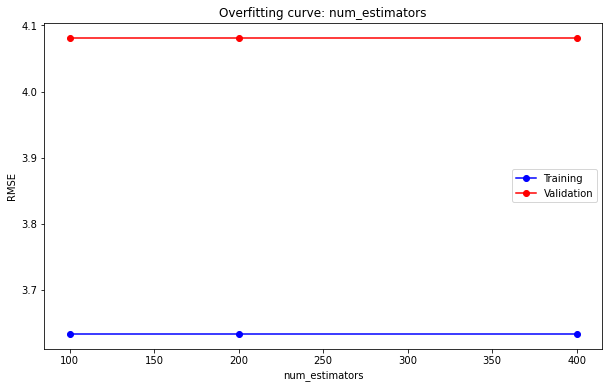

In [305]:
%%time
test_param_and_plot(XGBRegressor, 'num_estimators', [100, 200, 400], **best_params)

Seems like 500 estimators has the lowest validation loss. However, it also takes a long time. Let's stick with 250 for now.

In [ ]:
best_params['num_estimators'] = 250

### Max Depth

[04:08:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:09:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:09:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_estimators" } might not be used.


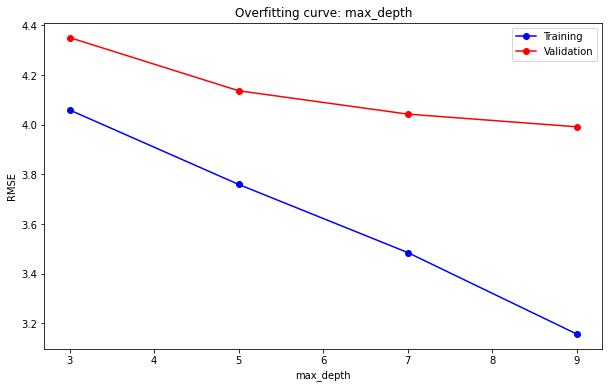

In [309]:
test_param_and_plot(XGBRegressor, 'max_depth', [3, 5, 7, 9], **best_params )

Looks like a max depth of 9 is ideal.

In [311]:
best_params['max_depth'] = 9

### Learning Rate

[04:06:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "learnign_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "learnign_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:08:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "learnign_rate" } might not be used.

  

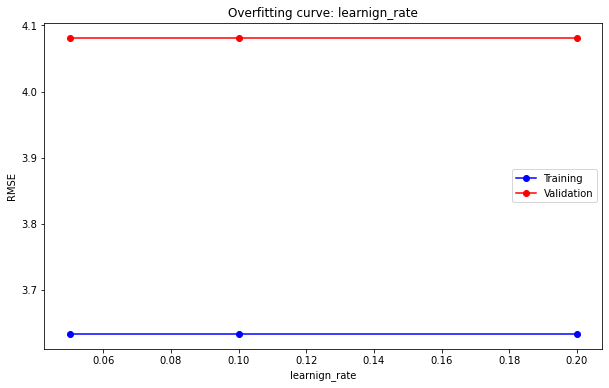

In [307]:
test_param_and_plot(XGBRegressor, 'learnign_rate', [0.05, 0.1, 0.2, 2.5], **best_params )

Seems like the best learning rate is 0.25.

In [312]:
best_params['learning_rate'] = 0.25

### Other Parameters

Similarly we can experiment with other parameters. 

Here's a set of parameters that works well:

In [313]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', 
                               n_jobs=-1, 
                               random_state=42,
                               n_estimators=500, 
                               max_depth=5, 
                               learning_rate=0.1, 
                               subsample=0.8, 
                               colsample_bytree=0.8)

In [314]:
xgb_model_final.fit(train_inputs, train_targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [315]:
evaluate(xgb_model_final)

(3.1363447,
 3.9406412,
 array([ 6.438649 ,  7.4957404, 10.06592  , ..., 11.351695 ,  8.857836 ,
        10.441122 ], dtype=float32),
 array([14.053961 ,  6.001948 , 48.01751  , ...,  7.6946616, 30.48347  ,
         8.797455 ], dtype=float32))

In [317]:
predict_and_submit(xgb_model_final, test_inputs, 'xgb_tuned_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.838984
1,2015-01-27 13:08:24.0000003,11.087189
2,2011-10-08 11:53:44.0000002,4.945352
3,2012-12-01 21:12:12.0000002,8.716990
4,2012-12-01 21:12:12.0000003,15.831882
...,...,...
9909,2015-05-10 12:37:51.0000002,8.925940
9910,2015-01-12 17:05:51.0000001,12.001342
9911,2015-04-19 20:44:15.0000001,53.249519
9912,2015-01-31 01:05:19.0000005,20.082941




This puts us at the ~460th position out of 1483 i.e. top 30%. This is pretty amazing considering:

- We are using just 1% of the training data
- We are only using a single model (most top submissions use ensembles)
- Our best model takes just 10 minutes to train (as oppposed to hours/days)
- We haven't fully optimized the hyperparameters yet

Let's save the weights of this model. Follow this guide: https://scikit-learn.org/stable/modules/model_persistence.html

**Exercises**: 

1. Tune hyperparameters for Linear Regression & random forests.
2. Repeat with 3%, 10%, 30% and 100% of the training set. How much reduction in error does 100x more data produce?
3. Ensemble (average) the results from multiple models and observe if they're better than individual models.

### Save Model Weights to Google Drive (Optional)

We can save all the output files we've created to Google Drive, so that we can reuse them later if required.

Follow these guides: 
- [https://scikit-learn.org/stable/modules/model_persistence.html](https://scikit-learn.org/stable/modules/model_persistence.html)
- [https://colab.research.google.com/notebooks/io.ipynb](https://colab.research.google.com/notebooks/io.ipynb)

## 9. Train on GPU with entire dataset (Optional)

Steps:
- Install `dask`, `cudf` and `cuml`
- Load the dataset to GPU
- Create training and validation set
- Perform feature engineering
- Train XGBoost `cuml` model
- Make predictions & submit

Follow these guides and fill out the empty cells below:
- [https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24](https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24)
- [https://jovian.ai/allenkong221/nyc-taxi-fare-rapids-dask-gpu/v/1?utm_source=embed#C10](https://jovian.ai/allenkong221/nyc-taxi-fare-rapids-dask-gpu/v/1?utm_source=embed#C10)
- [https://developer.nvidia.com/blog/accelerating-xgboost-on-gpu-clusters-with-dask/](https://developer.nvidia.com/blog/accelerating-xgboost-on-gpu-clusters-with-dask/)
- [https://rapids.ai/xgboost.html](https://rapids.ai/xgboost.html)

### Install `dask`, `cudf` and `cuml`

In [320]:
#!pip install dask
!pip install cudf
#!pip install cuml

  Using cached cudf-0.6.1.post1.tar.gz (1.1 kB)
  Running setup.py clean for cudf
Failed to build cudf
    Running setup.py install for cudf: started
    Running setup.py install for cudf: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\desou\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\desou\\AppData\\Local\\Temp\\pip-install-a7p4c780\\cudf_1cc9161ed7064babaac5cc6a65e2ec4d\\setup.py'"'"'; __file__='"'"'C:\\Users\\desou\\AppData\\Local\\Temp\\pip-install-a7p4c780\\cudf_1cc9161ed7064babaac5cc6a65e2ec4d\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\desou\AppData\Local\Temp\pip-wheel-jou2ctkx'
       cwd: C:\Users\desou\AppData\Local\Temp\pip-install-a7p4c780\cudf_1cc9161ed7064babaac5cc6a65e2ec4d\
  Complete output (25 lines):
  running bdist_wheel
  running build
  installing to build\bdist.win-amd64\wheel
  running install
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\desou\AppData\Local\Temp\pip-ins

### Load the data

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import numba, socket
#import cudf
import dask, dask_cudf
from dask_cuda import LocalCUDACluster
from dask.delayed import delayed
import dask.dataframe as dd
from dask.distributed import Client, wait, LocalCluster
from dask_ml.model_selection import train_test_split

### Create training & validation set

### Perform feature engineering

### Train XGBoost model on GPU

### Make Predictions & Submit

## 10. Document & Publish Your Work

> _**TIP #13**: Always document & publish your projects online. They help improve your understanding, showcase your skills & often lead to inbound job opportunities._

- Add explanations using Markdown
- Clean up the code & create functions
- Publish notebook to Jovian
- Write a blog post and embed

Follow this guide: [https://www.youtube.com/watch?v=NK6UYg3-Bxs ](https://www.youtube.com/watch?v=NK6UYg3-Bxs )

## References

* Dataset: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview
* Missing semester (Shell scripting): https://missing.csail.mit.edu/
* Opendatsets library: https://github.com/JovianML/opendatasets 
* EDA project from scratch: https://www.youtube.com/watch?v=kLDTbavcmd0
* GeoPy: https://geopy.readthedocs.io/en/stable/#module-geopy.distance 
* Blog post by Allen Kong: https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24 
* Machine Learning with Python: Zero to GBMs - https://zerotogbms.com 
* Experiment tracking spreadsheet: https://bit.ly/mltrackingsheet 
* Pandas datetime components: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components 
* Haversine distance: https://en.wikipedia.org/wiki/Haversine_formula 
* Haversine distance with Numpy: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas 
* RAPIDS (parent project for cudf and cuml): https://rapids.ai/
* Data Science blog post from scratch: https://www.youtube.com/watch?v=NK6UYg3-Bxs 
* Examples of Machine Learning Projects:
    * Walmart Store Sales: https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm
    * Used Car Price Prediction: https://jovian.ai/kara-mounir/used-cars-prices 
    * Lithology Prediction: https://jovian.ai/ramysaleem/ml-project-machine-predicting-lithologies
    * Ad Demand Prediction: https://jovian.ai/deepa-sarojam/online-ad-demand-prediction-ml-prj 
    * Financial distress prediction: https://jovian.ai/sm-wilson/ml-project-financial-distress-prediction
    * Credit scoring: https://jovian.ai/shenghongzhong/credit-scores-algorithms-ml-2

